# End to end prediction for kaggle competition

Hey guys please go through this notebook. I need help improving this part by part

In [1]:
# I've moved the trained cnn model so it can be imported easily
from models.model0 import model, getXandIndex
sid = "5acc9d63b5fd"
# getXandIndex will retrieve acceleration data from files in a way that the model can process
# index is the index of all data points that the model will make predictions on
X, index = getXandIndex(sid)
y = model(X)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 72, 32)         3232      
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 9, 32)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 10)                2890      
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 6144 (24.00 KB)
Trainable params: 6144 (24.00 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [2]:
# dataloader is for loading the acceleration data yourself
import dataloader
data = dataloader.load_sid(sid)
y_ = (data.activity=='Sleeping').astype(int).loc[index]

In [3]:
import visual
import pandas as pd
import os
%matplotlib qt
anime = visual.scrol_predictions(y[:,1], y_, data.loc[index, 'timestamp'], pd.Timedelta(1,'day'))
# anime.save(os.path.join('vids',f"{sid}_raw_preds.mp4"))

  0%|          | 0/816 [00:00<?, ?it/s]

In [20]:
import importlib
import postprocess
importlib.reload(postprocess)

<module 'postprocess' from 'd:\\Projects\\ChildMindSleep\\postprocess.py'>

In [32]:
# we need to create good post processing techniques
# the raw model output is not very clean
from postprocess import smooth, tabulate, smooth_center, smooth_spread

res = smooth(y[:,1],48*12)
res = smooth(res,   48*12)
# res = smooth(res,   5*12)
preds = tabulate(res, index, data)
preds.loc[:, 'series_id'] = sid
preds.sample(5)

,event,step,score,series_id
24,onset,211789,1,5acc9d63b5fd
6,onset,56174,1,5acc9d63b5fd
38,onset,316120,1,5acc9d63b5fd
1,wakeup,13608,1,5acc9d63b5fd
11,wakeup,97169,1,5acc9d63b5fd


In [22]:
import visual
%matplotlib qt
anime = visual.scrol_predictions(res, y_, data.loc[index, 'timestamp'], pd.Timedelta(1,'day'))
# anime.save(os.path.join('vids',f"{sid}_smoothened_preds.mp4"))

  0%|          | 0/816 [00:00<?, ?it/s]

In [6]:
import pandas as pd
events = pd.read_csv(r"data\\train_events.csv")
sid_events = events.loc[events['series_id']==sid]

In [33]:
import evaluations
evaluations.scoreIt(preds_df=preds, targs_df=sid_events)

0.5865

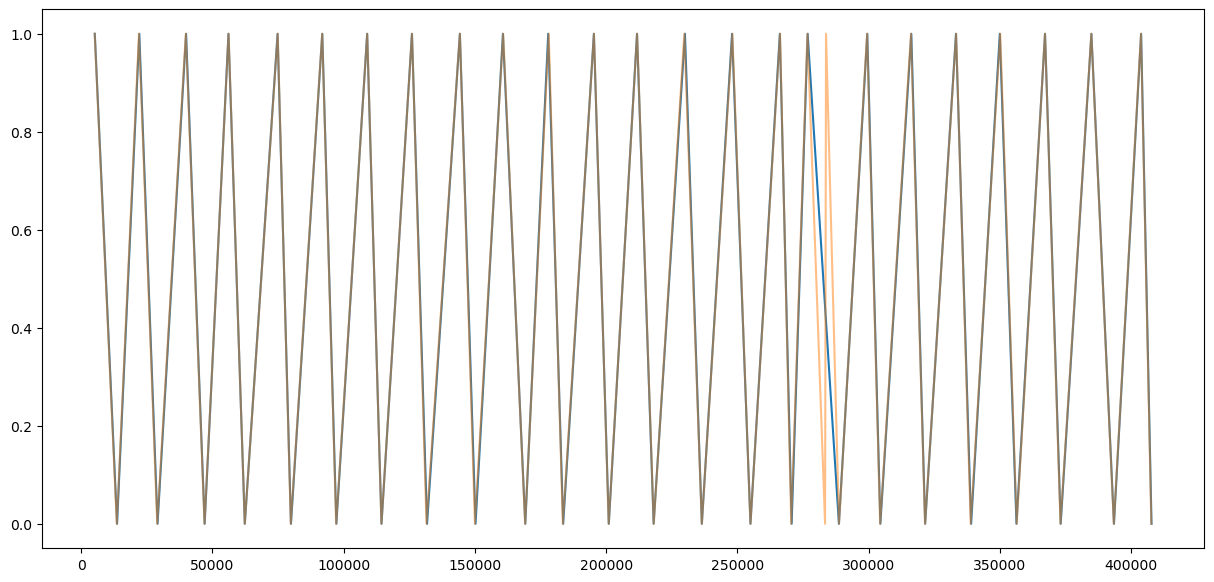

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.plot(sid_events.step, sid_events.event=="onset")
plt.plot(preds.step, preds.event=="onset", alpha=0.5)